In [1]:
import numpy as np
import os

from cil.io import TXRMDataReader
from cil.processors import TransmissionAbsorptionConverter
from cil.plugins.tigre import FBP
from cil.utilities.display import show2D, show_geometry

from cil.recon import FDK

In [2]:
# File Paths
base_dir = os.path.abspath("/mnt/data/edo/Data")
data_name = "Walnut"
filename = os.path.join(base_dir, data_name, "valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm")

In [3]:

data = TXRMDataReader(file_name=filename).read()

In [4]:

data = TransmissionAbsorptionConverter()(data)

In [5]:
# Decide on the reconstruction volume
data.reorder('tigre')
resolution = 1
ig = data.geometry.get_ImageGeometry(resolution=resolution)
ig.voxel_num_x = int(360 * 2 / resolution)
ig.voxel_num_y = int(370 * 2 / resolution)

In [ ]:
show_geometry(data.geometry)

In [6]:
# run fdk
fdk = FDK(data, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 1601
	vertical: 1024
	horizontal: 1024

Reconstruction Volume:
	vertical: 1024
	horizontal_y: 740
	horizontal_x: 720

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	FFT order: 11
	Filter_inplace: False



In [7]:
from cil.utilities.jupyter import islicer
islicer (recon, direction='horizontal_x')

interactive(children=(IntSlider(value=360, continuous_update=False, description='horizontal_x', max=719), Floa…

IntSlider(value=360, continuous_update=False, description='horizontal_x', max=719)

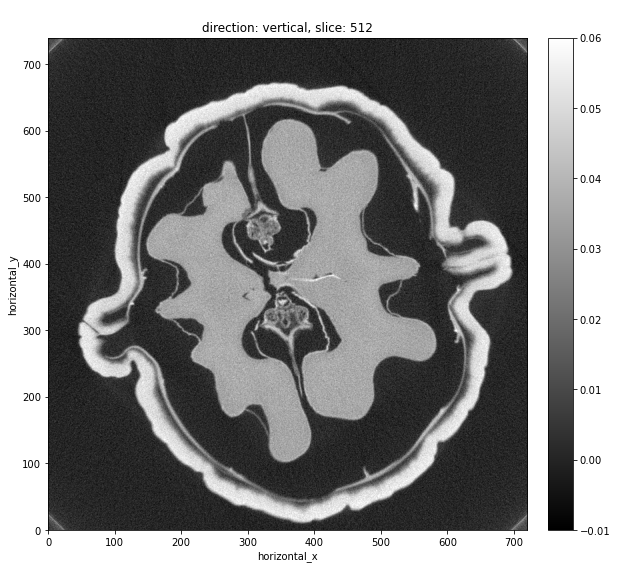

In [8]:
show2D(recon, fix_range=(-0.01, 0.06), cmap='gray')

In [ ]:
class AcquisitionGeometrySubsetGenerator(object):
    '''AcquisitionGeometrySubsetGenerator is a factory that helps generating subsets of AcquisitionData
    
    AcquisitionGeometrySubsetGenerator generates the indices to slice the data array in AcquisitionData along the 
    angle dimension with 4 methods:

    1. random: picks randomly between all the angles. Subset may contain same projection as other
    2. random_permutation: generates a number of subset by a random permutation of the indices, thereby no subset contain the same data.
    3. uniform: divides the angles in uniform subsets without permutation
    4. stagger: generates number_of_subsets by interleaving them, e.g. generating 2 subsets from [0,1,2,3] would lead to [0,2] and [1,3]

    The factory is not to be used directly rather from the AcquisitionGeometry class.

    '''
    
    ### Changes in the Operator required to work as OS operator
    @staticmethod
    def generate_subset(acquisition_data, number_of_subsets, method='random'):
        
        ag = acquisition_data.geometry
        angles = ag.angles.copy()
        if method == 'random':
            indices = [ AcquisitionGeometrySubsetGenerator.random_indices(angles, number_of_subsets) 
              for _ in range(number_of_subsets) ] 
            
        elif method == 'random_permutation':
            rndidx = np.asarray(range(len(angles)))
            np.random.shuffle(rndidx)
            indices = AcquisitionGeometrySubsetGenerator.uniform_groups_indices(rndidx, number_of_subsets)
            
        elif method == 'uniform':
            rndidx = np.asarray(range(len(angles)))
            indices = AcquisitionGeometrySubsetGenerator.uniform_groups_indices(rndidx, number_of_subsets)
            
        elif method == 'stagger':
            idx = np.asarray(range(len(angles)))
            indices = AcquisitionGeometrySubsetGenerator.staggered_indices(idx, number_of_subsets)
        else:
            raise ValueError('Can only do {}. got {}'.format(['random', 'random_permutation', 'uniform'], method))
        
        # return indices    
        subsets = [] 
        for idx in indices:
            g = ag.copy()
            angles = ag.angles[idx]
            g.set_angles(angles)
            data = g.allocate(0)
            data.fill(acquisition_data.as_array()[idx])
            subsets.append( data )
        return subsets
    
    @staticmethod
    def uniform_groups_indices(idx, number_of_subsets):
        indices = []
        groups = int(len(idx)/number_of_subsets)
        for i in range(number_of_subsets):
            ret = np.asarray(numpy.zeros_like(idx), dtype=np.bool)
            for j,el in enumerate(idx[i*groups:(i+1)*groups]):
                ret[el] = True
                
            indices.append(ret)
        return indices
    @staticmethod
    def random_indices(angles, number_of_subsets):
        N = int(numpy.floor(float(len(angles))/float(number_of_subsets)))
        indices = np.asarray(range(len(angles)))
        np.random.shuffle(indices)
        indices = indices[:N]
        ret = np.asarray(np.zeros_like(angles), dtype=np.bool)
        for i,el in enumerate(indices):
            ret[el] = True
        return ret
    @staticmethod
    def staggered_indices(idx, number_of_subsets):
        indices = []
        # groups = int(len(idx)/number_of_subsets)
        for i in range(number_of_subsets):
            ret = np.asarray(np.zeros_like(idx), dtype=np.bool)
            indices.append(ret)
        i = 0
        while i < len(idx):    
            for ret in indices:
                ret[i] = True
                i += 1
                if i >= len(idx):
                    break
                
        return indices
    @staticmethod
    def get_new_indices(index):
        newidx = []
        for idx in index:
            ai = np.where(idx == True)[0]
            for i in ai:
                newidx.append(i)
        return np.asarray(newidx)



In [ ]:
from cil.optimisation.algorithms import SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import MixedL21Norm, L2NormSquared, BlockFunction, IndicatorBox
from cil.plugins.tigre import ProjectionOperator

alpha = 0.02
num_subsets = 10 * 20
subsets = AcquisitionGeometrySubsetGenerator.generate_subset(data, num_subsets, method='stagger') 

operators = []
functions = []

for i,sub in enumerate(subsets):
    operators.append( ProjectionOperator(ig, sub.geometry) )
    if i == 0:
        norm = operators[i].norm()
    else:
        operators[i]._norm = norm
    functions.append( L2NormSquared(b=sub) )
operators.append( GradientOperator(ig) )
functions.append( alpha * MixedL21Norm() )

K = BlockOperator(*operators)
f = BlockFunction(*functions)
g = IndicatorBox(lower=0)

algo = SPDHG(f=f,g=g,operator=K, max_iteration=num_subsets * 5)

Initialised GradientOperator with C backend running with  16  threads
SPDHG setting up
SPDHG configured


In [ ]:
from functools import partial
# calculate the objective only on the first subset (for speed)
def update_objective(self):
    # p1 = self.f(self.operator.direct(self.x)) + self.g(self.x)
    p1 = 0.
    for i,op in enumerate(self.operator.operators):
        if i > 1:
            break
        p1 += self.f[i](op.direct(self.x))
    p1 += self.g(self.x)

    d1 = - self.f.convex_conjugate(self.y_old)
    tmp = self.operator.adjoint(self.y_old)
    tmp *= -1
    d1 -= self.g.convex_conjugate(tmp)

    self.loss.append([p1, d1, p1-d1])
algo.update_objective = partial(update_objective, algo)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    2.74550e+06  -0.00000e+00    2.74550e+06


/mnt/data/edo/miniconda3/envs/cildev/lib/python3.8/site-packages/cil/framework/framework.py:2403: RuntimeWarning: invalid value encountered in true_divide
  out = pwop(self.as_array() , x2.as_array() , *args, **kwargs )


       20       1000         7.941                                            
       40       1000         6.888                                            
       60       1000         6.555                                            
       80       1000         6.373                                            
      100       1000         6.265                                            
      120       1000         6.194                                            
      140       1000         6.142                                            
      160       1000         6.104                                            
      180       1000         6.084                                            
      200       1000         6.063    1.01900e+05  -1.97511e+08    1.97613e+08
----------------------------------------------------------------------------
      200       1000         6.063    1.01900e+05  -1.97511e+08    1.97613e+08
Stop criterion has been reached.



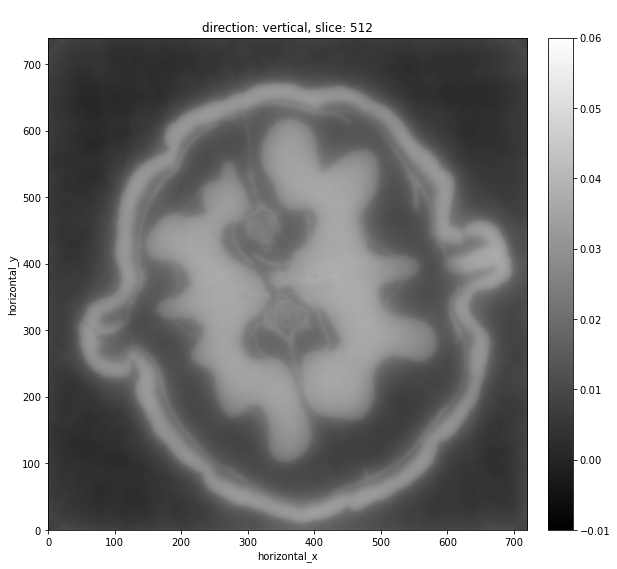

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
      200       1000         6.063    1.01900e+05  -1.97511e+08    1.97613e+08
      220       1000         6.018                                            
      240       1000         5.960                                            
      260       1000         5.959                                            
      280       1000         5.922                                            
      300       1000         5.890                                            
      320       1000         5.861                                            
      340       1000         5.841                                            
      360       1000         5.821                                            
      380       1000         5.799                                            
      400       1000         5.779    6.39193e+04  -

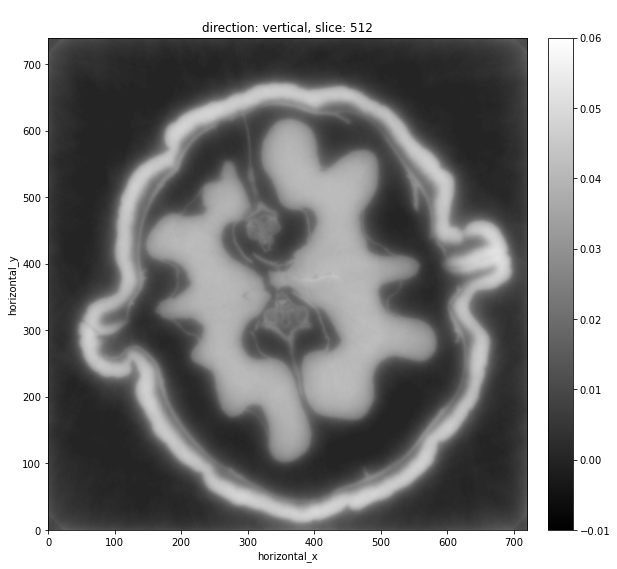

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
      400       1000         5.779    6.39193e+04  -9.36210e+07    9.36849e+07
      420       1000         5.769                                            
      440       1000         5.752                                            
      460       1000         5.743                                            
      480       1000         5.811                                            
      500       1000         5.870                                            
      520       1000         5.931                                            
      540       1000         5.920                                            
      560       1000         5.904                                            
      580       1000         5.890                                            
      600       1000         5.880    5.66197e+04  -

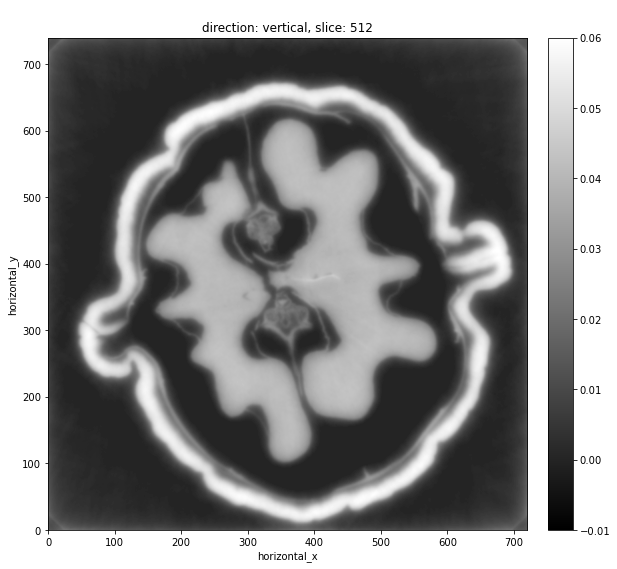

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
      600       1000         5.880    5.66197e+04  -5.43361e+07    5.43927e+07
      620       1000         5.866                                            
      640       1000         5.855                                            
      660       1000         5.843                                            
      680       1000         5.836                                            
      700       1000         5.824                                            
      720       1000         5.814                                            
      740       1000         5.805                                            
      760       1000         5.795                                            
      780       1000         5.787                                            
      800       1000         5.778    5.28119e+04  -

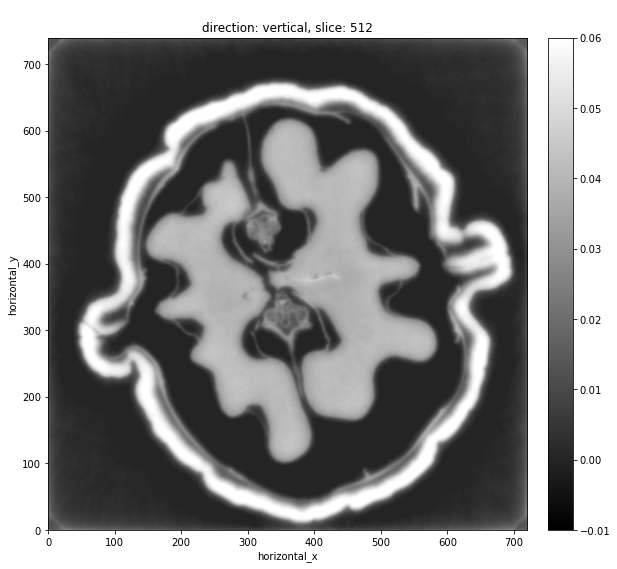

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
      800       1000         5.778    5.28119e+04  -2.92237e+07    2.92765e+07
      820       1000         5.770                                            
      840       1000         5.804                                            
      860       1000         5.796                                            
      880       1000         5.788                                            
      900       1000         5.827                                            
      920       1000         5.822                                            
      940       1000         5.815                                            
      960       1000         5.807                                            
      980       1000         5.799                                            
     1000       1000         5.796    5.11397e+04  -

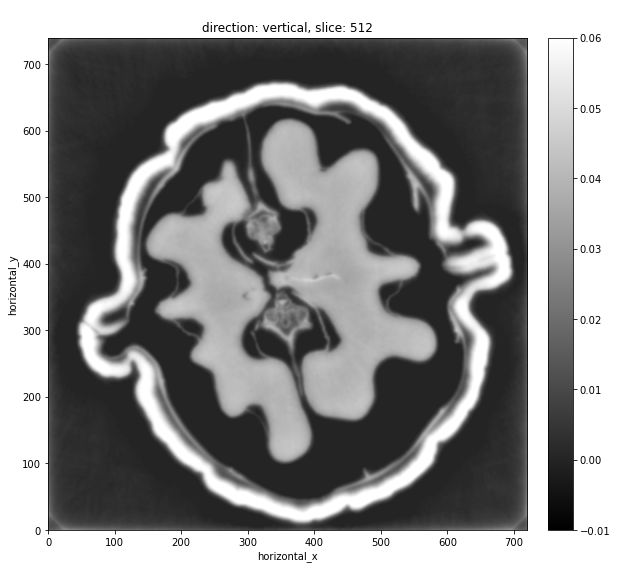

In [ ]:
algo.update_objective_interval = num_subsets
for i in range(5):
    algo.run(num_subsets, print_interval=num_subsets//10, verbose=2)
    show2D(algo.solution, fix_range=(-0.01, 0.06))

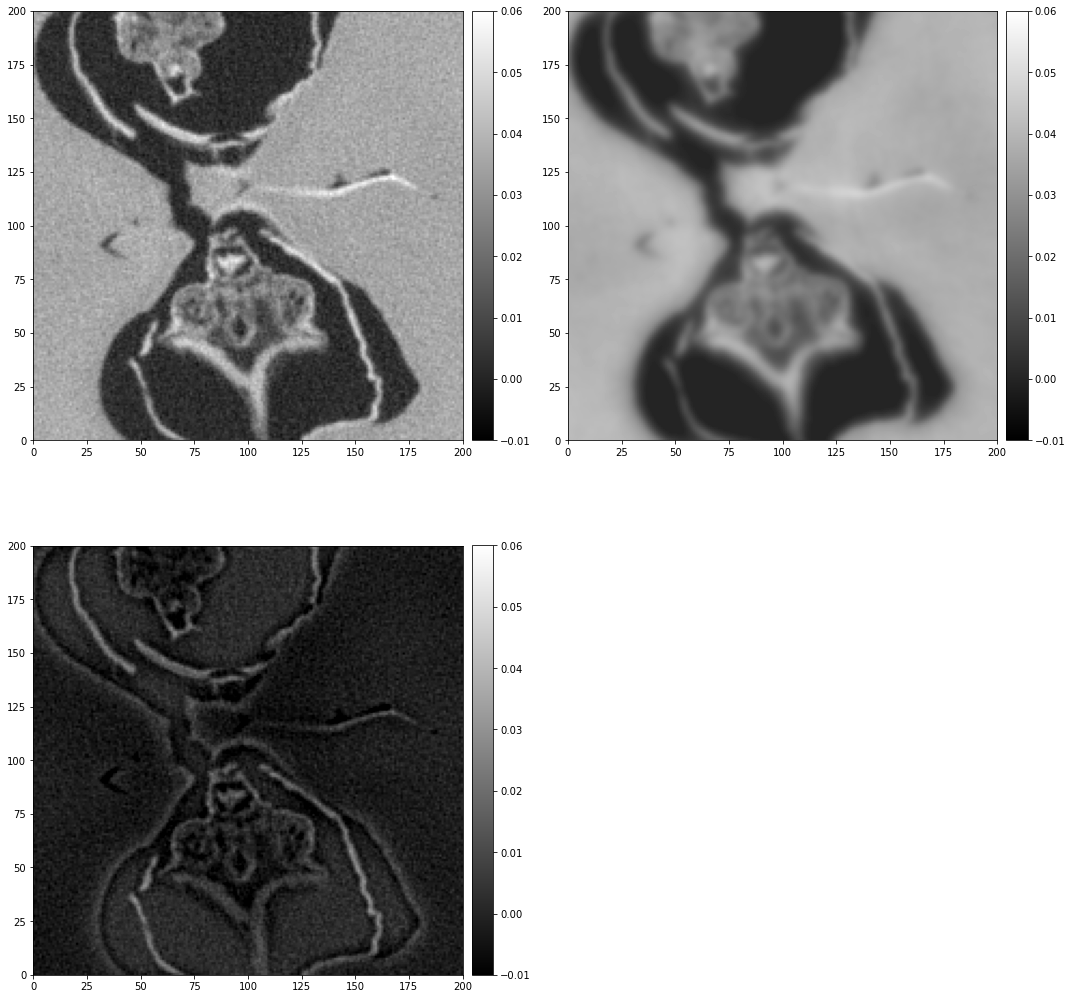

In [ ]:
show2D([el.get_slice(vertical='centre').as_array()[130*2:230*2,130*2:230*2]  for el in [recon, algo.solution, recon - algo.solution]], fix_range=(-0.01, 0.06))

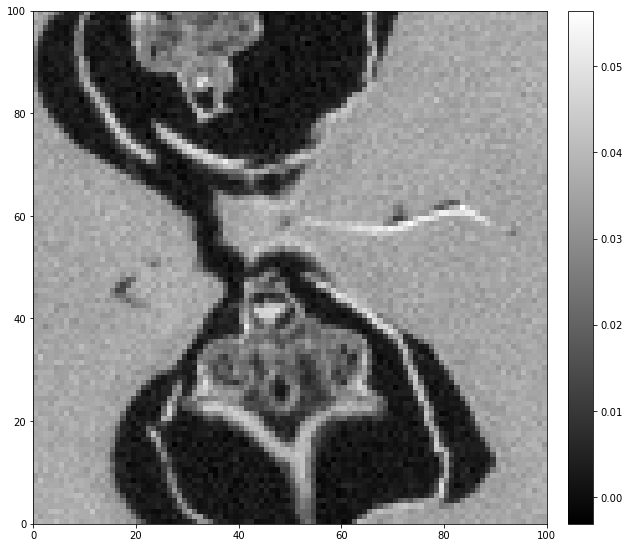

In [ ]:
show2D(recon.get_slice(vertical='centre').as_array()[130:230,130:230] )